# Two dimensional turbulence example

In this example, we initialize a random velocity field and observe its turbulent decay
in a two-dimensional domain. This example demonstrates:

  * How to run a model with no tracers and no buoyancy model.
  * How to use computed `Field`s to generate output.

## Install dependencies

First let's make sure we have all required packages installed.

```julia
using Pkg
pkg"add Oceananigans, CairoMakie"
```

## Model setup

We instantiate the model with an isotropic diffusivity. We use a grid with 128² points,
a fifth-order advection scheme, third-order Runge-Kutta time-stepping,
and a small isotropic viscosity.  Note that we assign `Flat` to the `z` direction.

Note!!! The grid is too coarse to resolve the smallest scales of turbulence (Kolmogorov scales).
If you have a GPU available, you can run this example with a 512x512 grid

In [1]:
using Oceananigans

grid = RectilinearGrid(size=(128, 128), extent=(2π, 2π), topology=(Periodic, Periodic, Flat))

advection   = UpwindBiased(order=5)
closure     = ScalarDiffusivity(ν=1e-5)
timestepper = :RungeKutta3

model = NonhydrostaticModel(; grid, advection, closure, timestepper)

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 128×128×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: UpwindBiased(order=5)
├── tracers: ()
├── closure: ScalarDiffusivity{ExplicitTimeDiscretization}(ν=1.0e-5)
├── buoyancy: Nothing
└── coriolis: Nothing

## Random initial conditions

Our initial condition randomizes `model.velocities.u` and `model.velocities.v`.
We ensure that both have zero mean for aesthetic reasons.

In [2]:
using Statistics

u, v, w = model.velocities

uᵢ(x, y) = 0.3 * randn()
vᵢ(x, y) = 0.3 * randn()

set!(model, u=uᵢ, v=vᵢ)

## Setting up a simulation

We set-up a simulation that stops at 50 time units, with an initial
time-step of 0.1, and with adaptive time-stepping and progress printing.

In [3]:
simulation = Simulation(model, Δt=0.2, stop_time=50)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 200 ms
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 50 seconds
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

The `TimeStepWizard` helps ensure stable time-stepping
with a Courant-Freidrichs-Lewy (CFL) number of 0.7.

In [4]:
conjure_time_step_wizard!(simulation, cfl=0.7, max_change=1.1, max_Δt=0.5)

## Logging simulation progress

We set up a callback that logs the simulation iteration and time every 100 iterations.

In [5]:
using Printf

function progress_message(sim)
    max_abs_u = maximum(abs, sim.model.velocities.u)
    walltime = prettytime(sim.run_wall_time)

    return @info @sprintf("Iteration: %04d, time: %1.3f, Δt: %.2e, max(|u|) = %.1e, wall time: %s\n",
                          iteration(sim), time(sim), sim.Δt, max_abs_u, walltime)
end

add_callback!(simulation, progress_message, IterationInterval(100))

## Output

We set up an output writer for the simulation that saves vorticity and speed every 20 iterations.

### Computing vorticity and speed

To make our equations prettier, we unpack `u`, `v`, and `w` from
the `NamedTuple` model.velocities:

In [6]:
u, v, w = model.velocities

NamedTuple with 3 Fields on 128×128×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo:
├── u: 128×128×1 Field{Face, Center, Center} on RectilinearGrid on CPU
├── v: 128×128×1 Field{Center, Face, Center} on RectilinearGrid on CPU
└── w: 128×128×1 Field{Center, Center, Face} on RectilinearGrid on CPU

Next we create two `Field`s that calculate
_(i)_ vorticity that measures the rate at which the fluid rotates
and is defined as

$$
ω = ∂_x v - ∂_y u \, ,
$$

In [7]:
ω = ∂x(v) - ∂y(u)

BinaryOperation at (Face, Face, Center)
├── grid: 128×128×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
└── tree: 
    - at (Face, Face, Center)
    ├── ∂xᶠᶠᶜ at (Face, Face, Center) via identity
    │   └── 128×128×1 Field{Center, Face, Center} on RectilinearGrid on CPU
    └── ∂yᶠᶠᶜ at (Face, Face, Center) via identity
        └── 128×128×1 Field{Face, Center, Center} on RectilinearGrid on CPU

We also calculate _(ii)_ the _speed_ of the flow,

$$
s = \sqrt{u^2 + v^2} \, .
$$

In [8]:
s = sqrt(u^2 + v^2)

UnaryOperation at (Face, Center, Center)
├── grid: 128×128×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
└── tree: 
    sqrt at (Face, Center, Center) via identity
    └── + at (Face, Center, Center)
        ├── ^ at (Face, Center, Center)
        │   ├── 128×128×1 Field{Face, Center, Center} on RectilinearGrid on CPU
        │   └── 2
        └── ^ at (Center, Face, Center)
            ├── 128×128×1 Field{Center, Face, Center} on RectilinearGrid on CPU
            └── 2

We pass these operations to an output writer below to calculate and output them during the simulation.

In [9]:
filename = "two_dimensional_turbulence"

simulation.output_writers[:fields] = JLD2OutputWriter(model, (; ω, s),
                                                      schedule = TimeInterval(0.6),
                                                      filename = filename * ".jld2",
                                                      overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(600 ms):
├── filepath: two_dimensional_turbulence.jld2
├── 2 outputs: (ω, s)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 29.5 KiB

## Running the simulation

Pretty much just

In [10]:
run!(simulation)

┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations /Users/simonesilvestri/.julia/packages/Oceananigans/2ELap/src/Simulations/run.jl:195
┌ Info: Iteration: 0000, time: 0.000, Δt: 1.00e-01, max(|u|) = 9.3e-01, wall time: 0 seconds
└ @ Main /Users/simonesilvestri/development/JuliaEO25/notebooks/day-4_2025-01-09/hands-on-session-simone/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sZmlsZQ==.jl:7
┌ Info:     ... simulation initialization complete (5.923 seconds)
└ @ Oceananigans.Simulations /Users/simonesilvestri/.julia/packages/Oceananigans/2ELap/src/Simulations/run.jl:239
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations /Users/simonesilvestri/.julia/packages/Oceananigans/2ELap/src/Simulations/run.jl:123
┌ Info:     ... initial time step complete (1.996 seconds).
└ @ Oceananigans.Simulations /Users/simonesilvestri/.julia/packages/Oceananigans/2ELap/src/Simulations/run.jl:132
┌ Info: Iteration: 0100, time: 6.960, Δt: 7.53e-02, max(|u|) = 3.0e-01, wall 

## Visualizing the results

We load the output.

In [11]:
ω_timeseries = FieldTimeSeries(filename * ".jld2", "ω")
s_timeseries = FieldTimeSeries(filename * ".jld2", "s")

times = ω_timeseries.times
nothing #hide

and animate the vorticity and fluid speed.

In [12]:
using CairoMakie
set_theme!(Theme(fontsize = 24))

fig = Figure(size = (800, 500))

axis_kwargs = (xlabel = "x",
               ylabel = "y",
               limits = ((0, 2π), (0, 2π)),
               aspect = AxisAspect(1))

ax_ω = Axis(fig[2, 1]; title = "Vorticity", axis_kwargs...)
ax_s = Axis(fig[2, 2]; title = "Speed", axis_kwargs...)
nothing #hide

We use Makie's `Observable` to animate the data. To dive into how `Observable`s work we
refer to [Makie.jl's Documentation](https://makie.juliaplots.org/stable/documentation/nodes/index.html).

In [13]:
n = Observable(1)

Observable(1)


Now let's plot the vorticity and speed.

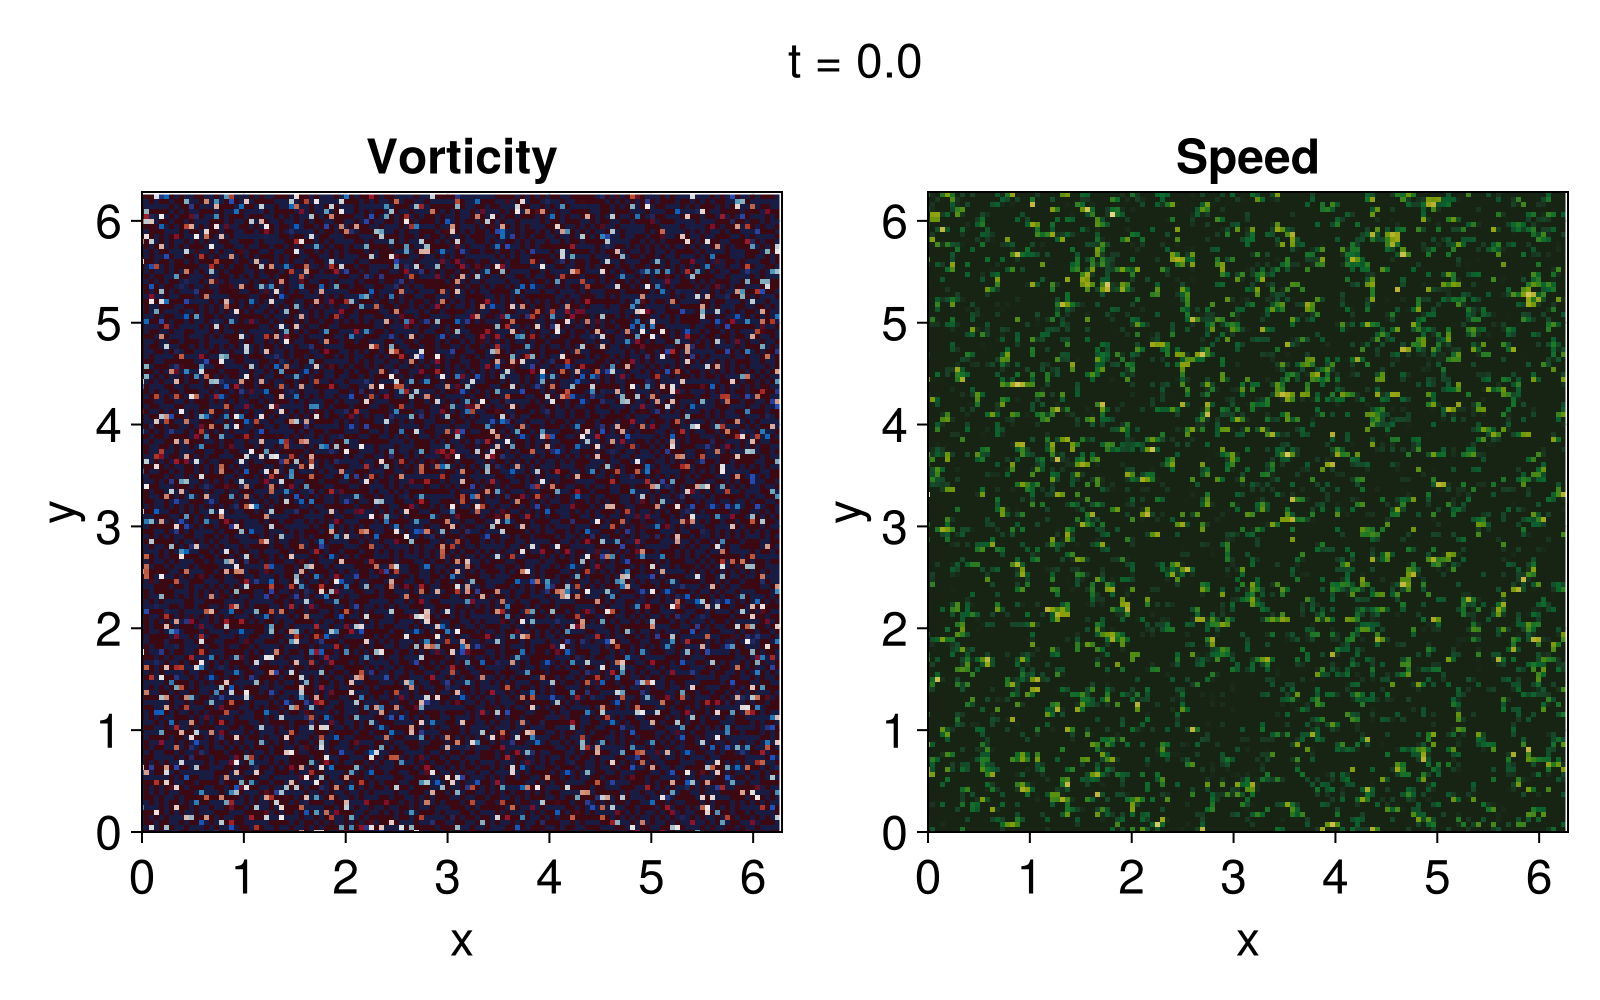

In [14]:
ω = @lift ω_timeseries[$n]
s = @lift s_timeseries[$n]

heatmap!(ax_ω, ω; colormap = :balance, colorrange = (-2, 2))
heatmap!(ax_s, s; colormap = :speed, colorrange = (0, 0.2))

title = @lift "t = " * string(round(times[$n], digits=2))
Label(fig[1, 1:2], title, fontsize=24, tellwidth=false)

current_figure() #hide
fig

Finally, we record a movie.

In [15]:
frames = 1:length(times)

@info "Making a neat animation of vorticity and speed..."

record(fig, filename * ".mp4", frames, framerate=24) do i
    @info "Frame $i of $(last(frames))"
    n[] = i
end
nothing #hide

┌ Info: Making a neat animation of vorticity and speed...
└ @ Main /Users/simonesilvestri/development/JuliaEO25/notebooks/day-4_2025-01-09/hands-on-session-simone/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X46sZmlsZQ==.jl:3
┌ Info: Frame 1 of 84
└ @ Main /Users/simonesilvestri/development/JuliaEO25/notebooks/day-4_2025-01-09/hands-on-session-simone/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X46sZmlsZQ==.jl:6
┌ Info: Frame 2 of 84
└ @ Main /Users/simonesilvestri/development/JuliaEO25/notebooks/day-4_2025-01-09/hands-on-session-simone/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X46sZmlsZQ==.jl:6
┌ Info: Frame 3 of 84
└ @ Main /Users/simonesilvestri/development/JuliaEO25/notebooks/day-4_2025-01-09/hands-on-session-simone/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X46sZmlsZQ==.jl:6
┌ Info: Frame 4 of 84
└ @ Main /Users/simonesilvestri/development/JuliaEO25/notebooks/day-4_2025-01-09/hands-on-session-simone/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X46sZml

![](two_dimensional_turbulence.mp4)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*